In [1]:
%reload_ext autoreload
%autoreload 2
import sys, os
sys.path.append(os.path.abspath(".."))

from src.data_eng.pipeline import run_pipeline


Create Config

add additional interaction features

In [2]:
from src.config import Config

conf = Config(
    #features=[], all features
    add_int_features=True,
    target={'horizon': 5, 'threshold': 0.01},
   # ticker_list=['AAPL','META'], #all tickers
    validate_cutoff='2022-01-01',      # FINAL TEST START
    fold_len='365D',
    fold_mode='expanding',             # or 'sliding'
    sliding_train_years=None,          # set e.g. 5 if using sliding
    embargo_days=None                  # defaults to horizon=5
)

In [6]:
run_pipeline(conf)

begin fetching data from yfinance...
['AAPL', 'MSFT', 'NVDA', 'GOOGL', 'AMZN', 'META', 'TSLA', 'AVGO', 'TSM', 'ORCL', 'WMT', 'JPM', 'INTC', 'UNH', 'HD']
saved: ../data/raw/AAPL.csv
saved: ../data/raw/MSFT.csv
saved: ../data/raw/NVDA.csv
saved: ../data/raw/GOOGL.csv
saved: ../data/raw/AMZN.csv
saved: ../data/raw/META.csv
saved: ../data/raw/TSLA.csv
saved: ../data/raw/AVGO.csv
saved: ../data/raw/TSM.csv
saved: ../data/raw/ORCL.csv
saved: ../data/raw/WMT.csv
saved: ../data/raw/JPM.csv
saved: ../data/raw/INTC.csv
saved: ../data/raw/UNH.csv
saved: ../data/raw/HD.csv
done fetching data
being data cleaning...
done cleaning data
begin feature engineering
make features for AAPL
make features for MSFT
make features for NVDA
make features for GOOGL
make features for AMZN
make features for META
make features for TSLA
make features for AVGO
make features for TSM
make features for ORCL
make features for WMT
make features for JPM
make features for INTC
make features for UNH
make features for HD
Done 

In [3]:
import numpy as np
import pandas as pd


## Hyperparameter tuning

### Linear SVC

In [4]:
from sklearn.svm import LinearSVC
# 1) build preprocessor with imputation to kill NaNs from lags/rolls
from src.modeling.eval import make_global_pipeline

def get_new_lvc(C):
    return LinearSVC(
            penalty="l2",
            loss="hinge",           
            dual=True,             
            class_weight="balanced",
            C=C,
            max_iter=20000,         
            random_state=42
        )

In [14]:


from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import StratifiedKFold
from src.data_eng.folds import load_multi_ticker_collection
from src.modeling.global_pairs import build_global_fold_pairs

# 1) get data
collection = load_multi_ticker_collection(conf)

# 2) build global fold pairs
pairs = build_global_fold_pairs(collection)

C_grid = np.logspace(-4, 0, 15)  # or loguniform samples

inner_cv_rows = []   # per (outer_fold, C, inner_split) AUC
outer_rows = []      # per outer_fold summary
outer_results = []
for k, (Xtr, ytr, Xva, yva) in enumerate(pairs):
    num_cols = [c for c in Xtr.columns if c not in ("__ticker__", "Date")]
    inner = StratifiedKFold(n_splits=3, shuffle=False)

    best_auc, best_c = -np.inf, None

    for C in C_grid:
        aucs = []
        for inner_idx, (itrain, ival) in enumerate(inner.split(Xtr, ytr)):
            X_itr, X_iva = Xtr.iloc[itrain], Xtr.iloc[ival]
            y_itr, y_iva = ytr.iloc[itrain], ytr.iloc[ival]

            pipe = make_global_pipeline(num_cols, get_new_lvc(C))
            pipe.fit(X_itr, y_itr)
            s = pipe.decision_function(X_iva)
            auc = roc_auc_score(y_iva, s)
            aucs.append(auc)

            inner_cv_rows.append({
                "outer_fold": k,
                "inner_split": inner_idx,
                "C": C,
                "auc": auc,
            })

        mean_auc = float(np.mean(aucs))
        if mean_auc > best_auc:
            best_auc, best_c = mean_auc, C

    # Final model for this outer fold
    final_fold_pipe = make_global_pipeline(num_cols, get_new_lvc(best_c))
    final_fold_pipe.fit(Xtr, ytr)
    s_val = final_fold_pipe.decision_function(Xva)
    p_val = (s_val >= 0).astype(int)

    outer_rows.append({
        "fold": k,
        "C": best_c,
        "inner_mean_auc": best_auc,
        "val_auc": roc_auc_score(yva, s_val),
        "val_accuracy": (p_val == yva).mean(),
        "n_val": len(Xva),
    })

# pick a final C (e.g., median of best Cs)
import pandas as pd
inner_df = pd.DataFrame(inner_cv_rows)
outer_df = pd.DataFrame(outer_rows)
final_C = float(np.median(outer_df["C"]))


/home/mike/Git-projects/StockPrediction/.venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/mike/Git-projects/StockPrediction/.venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/mike/Git-projects/StockPrediction/.venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/mike/Git-projects/StockPrediction/.venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/mike/Git-projects/StockPrediction/.venv/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iteration

In [13]:
print("final_C (median of fold-best Cs):", final_C)

final_C (median of fold-best Cs): 0.00019306977288832496


### Inner CV mean AUC vs C

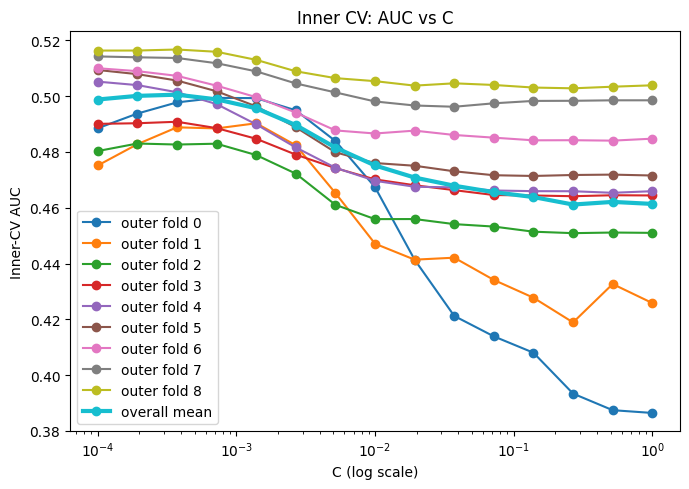

In [8]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(7,5))
for k in sorted(inner_df["outer_fold"].unique()):
    tmp = (inner_df[inner_df["outer_fold"] == k]
           .groupby("C", as_index=False)["auc"].mean()
           .sort_values("C"))
    plt.plot(tmp["C"], tmp["auc"], marker="o", label=f"outer fold {k}")

# Overall mean across outer folds (bold line)
overall = (inner_df.groupby("C", as_index=False)["auc"].mean().sort_values("C"))
plt.plot(overall["C"], overall["auc"], marker="o", linewidth=3, label="overall mean")

plt.xscale("log")
plt.xlabel("C (log scale)")
plt.ylabel("Inner-CV AUC")
plt.title("Inner CV: AUC vs C")
plt.legend(loc="best")
plt.tight_layout()
plt.show()


### C distribution across outer folds

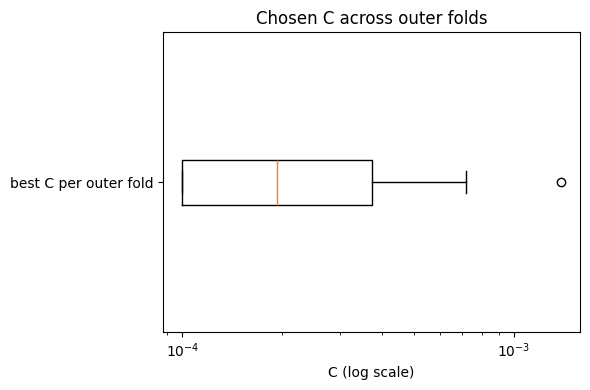

In [12]:
fig = plt.figure(figsize=(6,4))
plt.boxplot(outer_df["C"], vert=False, tick_labels=["best C per outer fold"])
plt.xscale("log")
plt.xlabel("C (log scale)")
plt.title("Chosen C across outer folds")
plt.tight_layout()
plt.show()


### Outer Fold Validation performance

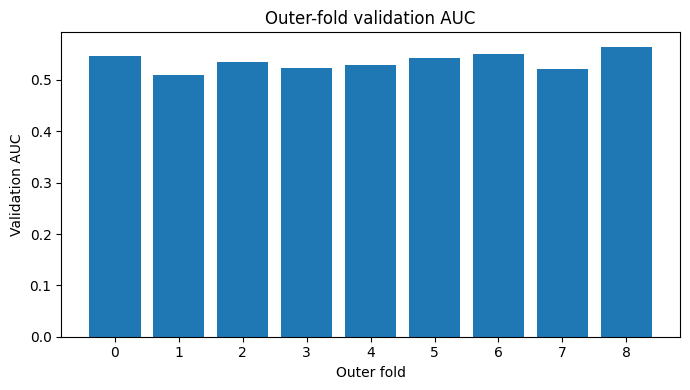

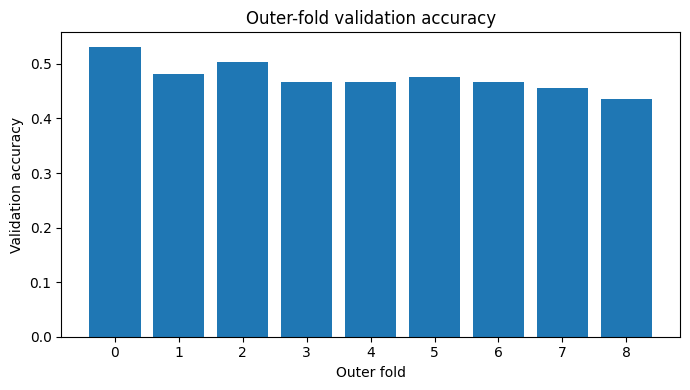

In [9]:
fig = plt.figure(figsize=(7,4))
plt.bar(outer_df["fold"].astype(str), outer_df["val_auc"])
plt.xlabel("Outer fold")
plt.ylabel("Validation AUC")
plt.title("Outer-fold validation AUC")
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(7,4))
plt.bar(outer_df["fold"].astype(str), outer_df["val_accuracy"])
plt.xlabel("Outer fold")
plt.ylabel("Validation accuracy")
plt.title("Outer-fold validation accuracy")
plt.tight_layout()
plt.show()


In [16]:
from src.modeling.global_pairs import build_global_insample_and_test
# 4) final test
X_ins, y_ins, X_test, y_test = build_global_insample_and_test(collection)
num_cols = [c for c in X_ins.columns if c not in ("__ticker__", "Date")]

mask_ins  = X_ins[num_cols].isna().any(axis=1)
X_ins     = X_ins.loc[~mask_ins]
y_ins     = y_ins.loc[~mask_ins]

mask_test = X_test[num_cols].isna().any(axis=1)
X_test    = X_test.loc[~mask_test]
y_test    = y_test.loc[~mask_test]



final_pipe = make_global_pipeline(num_cols, get_new_lvc(final_C))
final_pipe.fit(X_ins, y_ins)

final_auc = roc_auc_score(y_test, final_pipe.decision_function(X_test))
final_acc = accuracy_score(y_test, (final_pipe.decision_function(X_test) >= 0).astype(int))
print({"final_auc": final_auc, "final_acc": final_acc})

{'final_auc': 0.5378457217694667, 'final_acc': 0.4612177413557616}


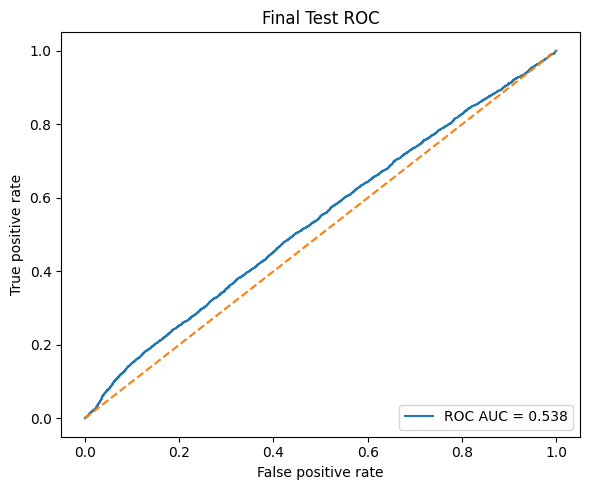

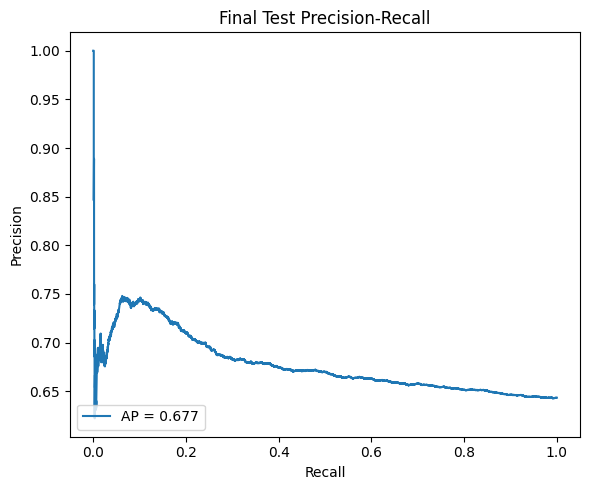

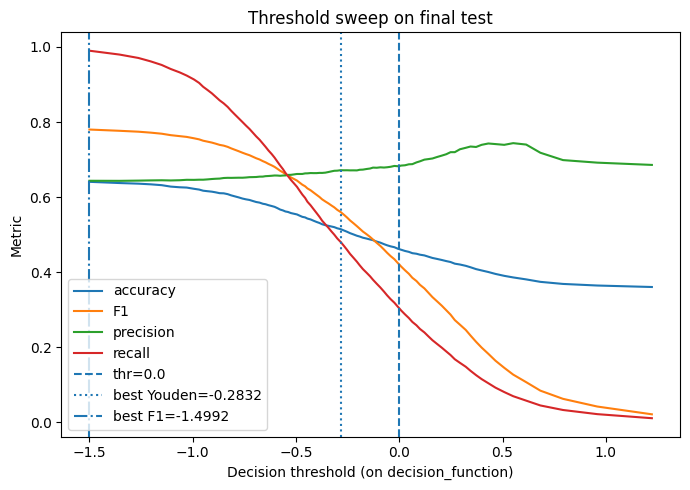

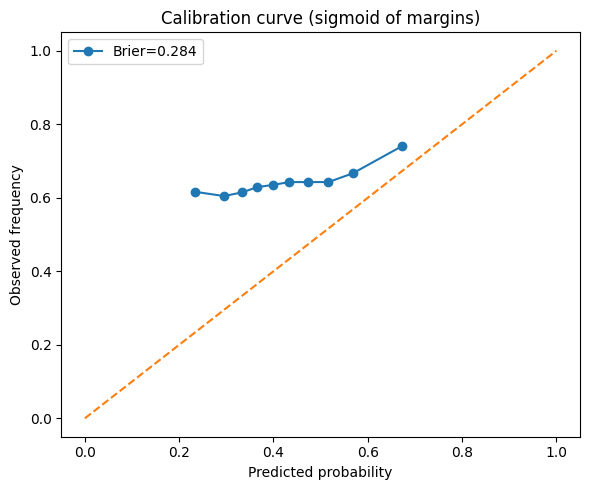

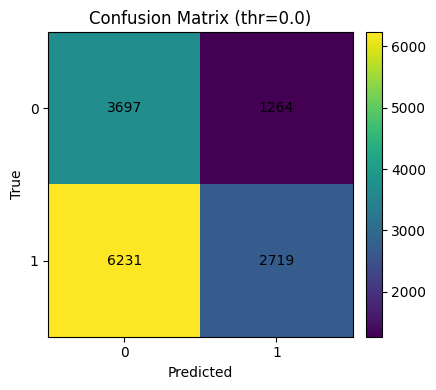

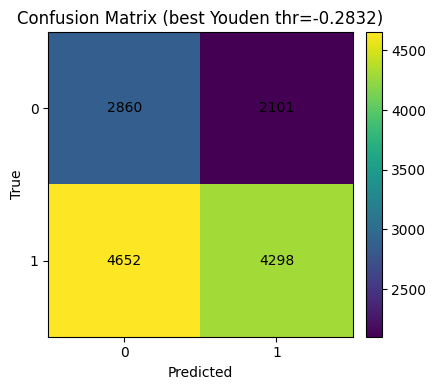

Report @ thr=0.0
              precision    recall  f1-score   support

           0      0.372     0.745     0.497      4961
           1      0.683     0.304     0.420      8950

    accuracy                          0.461     13911
   macro avg      0.528     0.525     0.459     13911
weighted avg      0.572     0.461     0.448     13911


Report @ best Youden
              precision    recall  f1-score   support

           0      0.381     0.576     0.459      4961
           1      0.672     0.480     0.560      8950

    accuracy                          0.515     13911
   macro avg      0.526     0.528     0.509     13911
weighted avg      0.568     0.515     0.524     13911



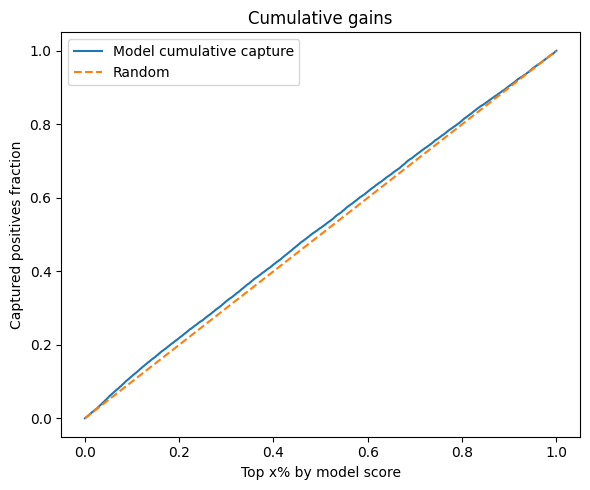

/tmp/ipykernel_18959/914216306.py:168: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  by_ticker = df_eval.groupby("ticker").apply(


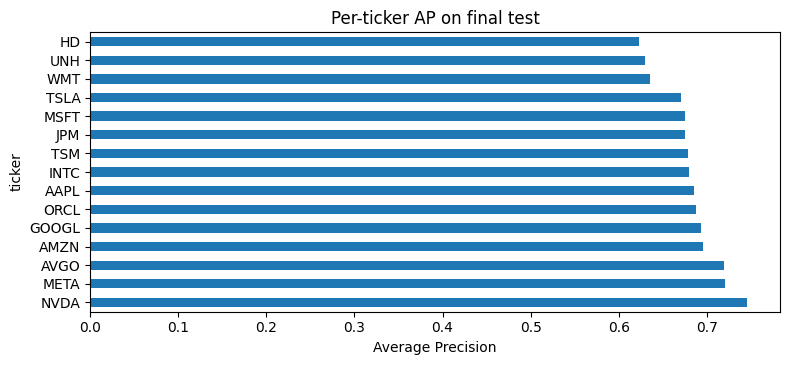

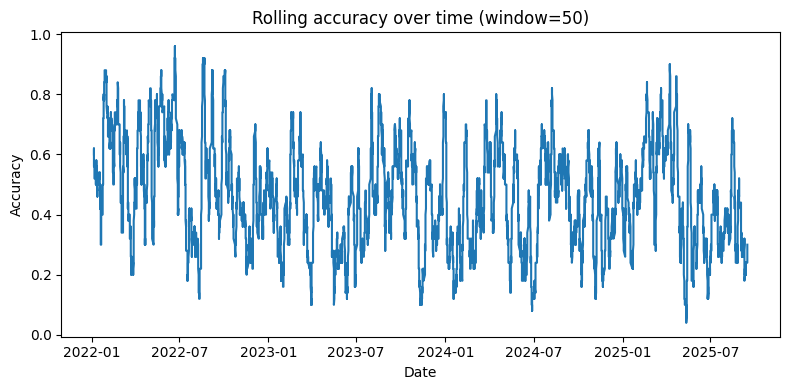

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve, average_precision_score,
    confusion_matrix, classification_report, brier_score_loss
)
from sklearn.calibration import calibration_curve

# 1) Get scores, preds, and a tidy frame for plotting
s_test = final_pipe.decision_function(X_test)
# If you want pseudo-probs from a margin, use a sigmoid squish. Not perfect, but fine for plots.
proba_test = 1 / (1 + np.exp(-s_test))
pred_test_50 = (s_test >= 0).astype(int)

df_eval = pd.DataFrame({
    "Date": X_test["Date"].values if "Date" in X_test.columns else pd.NaT,
    "ticker": X_test["__ticker__"].values if "__ticker__" in X_test.columns else "ALL",
    "y": y_test.values,
    "score": s_test,
    "proba": proba_test,
    "pred@0": pred_test_50,
})

# =========================
# 2) ROC curve + AUC
# =========================
fpr, tpr, roc_th = roc_curve(df_eval["y"], df_eval["score"])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("Final Test ROC")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# =========================
# 3) Precision-Recall + AP
# =========================
prec, rec, pr_th = precision_recall_curve(df_eval["y"], df_eval["score"])
ap = average_precision_score(df_eval["y"], df_eval["score"])

plt.figure(figsize=(6,5))
plt.plot(rec, prec, label=f"AP = {ap:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Final Test Precision-Recall")
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()

# =========================
# 4) Threshold sweep: metrics vs threshold
#    Shows where to cut the score if you don’t love 0.0
# =========================
def sweep_thresholds(y_true, scores, grid=None):
    if grid is None:
        grid = np.quantile(scores, np.linspace(0.01, 0.99, 99))
        grid = np.unique(np.r_[grid, 0.0])  # make sure 0 is included
    out = []
    for thr in grid:
        pred = (scores >= thr).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, pred).ravel()
        tpr = tp / (tp + fn) if (tp + fn) else 0.0
        fpr = fp / (fp + tn) if (fp + tn) else 0.0
        prec = tp / (tp + fp) if (tp + fp) else 0.0
        acc = (tp + tn) / (tp + tn + fp + fn)
        f1 = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) else 0.0
        youden = tpr - fpr
        out.append((thr, acc, f1, prec, tpr, fpr, youden))
    return pd.DataFrame(out, columns=["thr","acc","f1","precision","recall","fpr","youden"])

sweep = sweep_thresholds(df_eval["y"].values, df_eval["score"].values)
best_youden_thr = float(sweep.loc[sweep["youden"].idxmax(), "thr"])
best_f1_thr = float(sweep.loc[sweep["f1"].idxmax(), "thr"])

plt.figure(figsize=(7,5))
plt.plot(sweep["thr"], sweep["acc"], label="accuracy")
plt.plot(sweep["thr"], sweep["f1"], label="F1")
plt.plot(sweep["thr"], sweep["precision"], label="precision")
plt.plot(sweep["thr"], sweep["recall"], label="recall")
plt.axvline(0.0, linestyle="--", label="thr=0.0")
plt.axvline(best_youden_thr, linestyle=":", label=f"best Youden={best_youden_thr:.4f}")
plt.axvline(best_f1_thr, linestyle="-.", label=f"best F1={best_f1_thr:.4f}")
plt.xlabel("Decision threshold (on decision_function)")
plt.ylabel("Metric")
plt.title("Threshold sweep on final test")
plt.legend()
plt.tight_layout()
plt.show()

# =========================
# 5) Calibration (reliability) curve
#    Yes, margins aren’t probabilities, but the sigmoid’d scores give a sense of calibration
# =========================
prob_true, prob_pred = calibration_curve(df_eval["y"], df_eval["proba"], n_bins=10, strategy="quantile")
brier = brier_score_loss(df_eval["y"], df_eval["proba"])

plt.figure(figsize=(6,5))
plt.plot(prob_pred, prob_true, marker="o", label=f"Brier={brier:.3f}")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("Predicted probability")
plt.ylabel("Observed frequency")
plt.title("Calibration curve (sigmoid of margins)")
plt.legend()
plt.tight_layout()
plt.show()

# =========================
# 6) Confusion matrices at default and optimal thresholds
# =========================
def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4.5,4))
    im = plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ["0","1"])
    plt.yticks(tick_marks, ["0","1"])
    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm[i, j], ha="center", va="center")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

pred_0 = (df_eval["score"] >= 0.0).astype(int)
plot_cm(df_eval["y"], pred_0, "Confusion Matrix (thr=0.0)")

pred_youden = (df_eval["score"] >= best_youden_thr).astype(int)
plot_cm(df_eval["y"], pred_youden, f"Confusion Matrix (best Youden thr={best_youden_thr:.4f})")

# Optional: text report
print("Report @ thr=0.0")
print(classification_report(df_eval["y"], pred_0, digits=3))
print("\nReport @ best Youden")
print(classification_report(df_eval["y"], pred_youden, digits=3))

# =========================
# 7) Cumulative gains / lift (simple version)
# =========================
tmp = df_eval.sort_values("proba", ascending=False).reset_index(drop=True)
tmp["cum_positives"] = tmp["y"].cumsum()
total_pos = tmp["y"].sum()
pct = np.arange(1, len(tmp)+1) / len(tmp)
lift = tmp["cum_positives"] / (total_pos + 1e-9)

plt.figure(figsize=(6,5))
plt.plot(pct, lift, label="Model cumulative capture")
plt.plot([0,1],[0,1], linestyle="--", label="Random")
plt.xlabel("Top x% by model score")
plt.ylabel("Captured positives fraction")
plt.title("Cumulative gains")
plt.legend()
plt.tight_layout()
plt.show()

# =========================
# 8) Sanity checks: by ticker and over time
# =========================
if "__ticker__" in X_test.columns:
    by_ticker = df_eval.groupby("ticker").apply(
        lambda d: average_precision_score(d["y"], d["score"])
    ).sort_values(ascending=False)
    plt.figure(figsize=(8, max(3, 0.25*len(by_ticker))))
    by_ticker.plot(kind="barh")
    plt.xlabel("Average Precision")
    plt.title("Per-ticker AP on final test")
    plt.tight_layout()
    plt.show()

if "Date" in X_test.columns and pd.notna(df_eval["Date"]).any():
    df_time = df_eval.sort_values("Date")
    # rolling accuracy with a 50-sample window
    roll_acc = (df_time["pred@0"] == df_time["y"]).rolling(50).mean()
    plt.figure(figsize=(8,4))
    plt.plot(df_time["Date"], roll_acc)
    plt.title("Rolling accuracy over time (window=50)")
    plt.xlabel("Date")
    plt.ylabel("Accuracy")
    plt.tight_layout()
    plt.show()

# =========================
# 9) Save artifacts for Future
# =========================
df_eval.to_csv(conf.data_dir / 'model_metrics' / "final_test_predictions.csv", index=False)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr); plt.plot([0,1],[0,1],"--")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"ROC_AUC={roc_auc:.3f}"); plt.tight_layout()
plt.savefig(conf.data_dir / 'model_metrics' / "final_test_roc.png", dpi=160)
plt.close()


### Stochastic Gradient Descent Classifier

In [10]:
from sklearn.linear_model import SGDClassifier

def get_new_sgdclf(a):
    return SGDClassifier(
        penalty='l2',
        loss='hinge',
        alpha=a,
        class_weight='balanced',
        max_iter=2000,
        random_state=42
    )

In [11]:
coll_sgd = load_multi_ticker_collection(conf)
pairs_sgd = build_global_fold_pairs(coll_sgd)


cv_scores = []
for k, (Xtr, ytr, Xva, yva) in enumerate(pairs):
    num_cols = [c for c in Xtr.columns if c not in ("__ticker__", "Date")]
    
    # align drops: build a mask from *X* then apply to X and y
    mask_tr = Xtr[num_cols].isna().any(axis=1)
    Xtr = Xtr.loc[~mask_tr]
    ytr = ytr.loc[~mask_tr]

    mask_va = Xva[num_cols].isna().any(axis=1)
    Xva = Xva.loc[~mask_va]
    yva = yva.loc[~mask_va]

    

    pipe = make_global_pipeline(num_cols, model=get_new_sgdclf(a=.001))
    pipe.fit(Xtr, ytr)

    
    scores = pipe.decision_function(Xva)              
    preds  = (scores >= 0).astype(int)                # 0 threshold for hinge

    cv_scores.append({
        "fold": k,
        "roc_auc": roc_auc_score(yva, scores),
        "accuracy": accuracy_score(yva, preds),
        "n_val": len(Xva)
    })


In [12]:
cv_scores

[{'fold': 0,
  'roc_auc': 0.5487777533004987,
  'accuracy': 0.5480302212628171,
  'n_val': 3706},
 {'fold': 1,
  'roc_auc': 0.5439859440044083,
  'accuracy': 0.541014570966001,
  'n_val': 3706},
 {'fold': 2,
  'roc_auc': 0.5368376021437871,
  'accuracy': 0.5041857953011072,
  'n_val': 3703},
 {'fold': 3,
  'roc_auc': 0.49939322736210434,
  'accuracy': 0.510275824770146,
  'n_val': 3698},
 {'fold': 4,
  'roc_auc': 0.5288436579319654,
  'accuracy': 0.5223961144090664,
  'n_val': 3706},
 {'fold': 5,
  'roc_auc': 0.5346197973809476,
  'accuracy': 0.5213052858683926,
  'n_val': 3708},
 {'fold': 6,
  'roc_auc': 0.4926487373263685,
  'accuracy': 0.49232012934519,
  'n_val': 3711},
 {'fold': 7,
  'roc_auc': 0.5289953222134888,
  'accuracy': 0.47653721682847894,
  'n_val': 3708},
 {'fold': 8,
  'roc_auc': 0.5486712706592282,
  'accuracy': 0.507940930621343,
  'n_val': 3589}]